In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [3]:
#    text_to_clean = re.sub(r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', text_to_fuck)
def clean_input(text_to_clean):
    text_to_clean = text_to_clean.lower()
    text_to_clean = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', text_to_clean)
    text_to_clean = re.sub(r'[0-9]+', 'number', text_to_clean)
    text_to_clean = re.sub(r'[^a-zA-Z\u0621-\u064A\s]', '', text_to_clean)
    text_to_clean = re.sub(r'numbernumber+', 'number', text_to_clean)
    return text_to_clean



In [4]:
train=pd.read_csv('Dataset/train.csv')
test=pd.read_csv('Dataset/test.csv')
y_test=pd.read_csv('Dataset/submit.csv')
test=test.fillna(' ')
train=train.fillna(' ')


In [5]:
#Initializ y_train and x_train
train['text_merge'] = train['title'].astype(str) + ' ' + train['author'].astype(str) + ' ' + train['text'].astype(str)
x_train = train['text_merge']
y_train = train.drop(['id','title','author','text','text_merge'],axis=1)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)



(20800,)
(20800, 1)


In [6]:
#Initializ y_test and x_test

test['text_merge'] = test['title'].astype(str) + ' ' + test['author'].astype(str) + ' ' + test['text'].astype(str)
x_test = test['text_merge']
y_test = y_test.drop(['id'],axis=1)
y_test = np.array(y_test)
# x_test

In [7]:
for i in range(x_train.shape[0]):
    x_train.values[i] = clean_input(x_train[i])
x_train

0        house dem aide we didnt even see comeys letter...
1        flynn hillary clinton big woman on campus  bre...
2        why the truth might get you fired consortiumne...
3        number civilians killed in single us airstrike...
4        iranian woman jailed for fictional unpublished...
                               ...                        
20795    rapper ti trump a poster child for white supre...
20796    nfl playoffs schedule matchups and odds  the n...
20797    macys is said to receive takeover approach by ...
20798    nato russia to hold parallel exercises in balk...
20799    what keeps the fnumber alive david swanson   d...
Name: text_merge, Length: 20800, dtype: object

In [8]:
x_train.head()

0    house dem aide we didnt even see comeys letter...
1    flynn hillary clinton big woman on campus  bre...
2    why the truth might get you fired consortiumne...
3    number civilians killed in single us airstrike...
4    iranian woman jailed for fictional unpublished...
Name: text_merge, dtype: object

In [9]:
number_words = 20000
maxlen = 500
truncat = 'post'
padd = 'post'
token = '<OOV>'

tokenizer = Tokenizer(num_words = number_words , oov_token = token)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(sequences_train, maxlen = maxlen, truncating = truncat, padding = padd)

sequences_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(sequences_test, maxlen = maxlen, truncating = truncat, padding = padd)


In [10]:

print(X_train.shape)
print(X_test.shape)


(20800, 500)
(5200, 500)


In [11]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    return np.maximum(0,x)    

In [12]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))
def relu_derivative(x):
    return np.where(x > 0, 1, 0)
        

In [13]:
# Initialize the weights 
def init_weights(num_features, num_neuron): 
    l =[] 
    for i in range(num_features * num_neuron): 
        l.append(np.random.randn()) 
    return(np.array(l).reshape(num_features, num_neuron)) 

In [14]:
# COST FUNCTION
def mean_squared_error(y_true, y_pred):
    """ Calculates the mean squared error between y_true and y_pred. """
    return np.mean((y_true - y_pred)**2)
def binary_crossentropy(y_true, y_pred):
    """ Calculates the binary cross-entropy between y_true and y_pred. """
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # Clip values to prevent log(0)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [15]:
class NeuralNetwork:

    def __init__(self, x, y,hidden1,hidden2, out_layer,b):
        self.input      = x
        self.weights1   = init_weights(self.input.shape[1],hidden1)
        self.weights2   = init_weights(hidden1,hidden2)
        self.weights3   = init_weights(hidden2,out_layer)
        self.y          = y
        self.y_pred     = np.zeros(self.y.shape)
        self.loss       = []
        self.bias       = b

    def feedforward(self):
        self.layer1_out = sigmoid(np.dot(self.input,self.weights1))
        self.layer2_out = sigmoid(np.dot(self.layer1_out,self.weights2))
        self.y_pred     = sigmoid(np.dot(self.layer2_out,self.weights3))
        

    
    def backprop(self,l_rate):
        
        #cost =  binary_crossentropy(self.y,self.y_pred)
        cost1 = mean_squared_error(self.y,self.y_pred)
        cost = self.y - self.y_pred 
        d_output   = 2 * cost * sigmoid_derivative(self.y_pred)
        d_layer2   = np.dot(d_output,self.weights3.T) * sigmoid_derivative(self.layer2_out)
        d_layer1   = np.dot(d_layer2,self.weights2.T) * sigmoid_derivative(self.layer1_out)
        d_weights1 = np.dot(self.input.T,d_layer1)
        d_weights2 = np.dot(self.layer1_out.T,d_layer2)
        d_weights3 = np.dot(self.layer2_out.T,d_output)
        self.weights1 = self.weights1 + l_rate *  d_weights1 
        self.weights2 = self.weights2 + l_rate *  d_weights2
        self.weights3 = self.weights3 + l_rate *  d_weights3
        self.loss.append(cost1)
        

C:\Users\EM_K\AppData\Local\Temp\ipykernel_13896\2820709820.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Iteration 0:
Training Loss: 0.4644291977915448, Training Accuracy: 49.98%
Test Loss: 0.5501923076923076, Test Accuracy: 44.98%
----------------------------------------
Iteration 1:
Training Loss: 0.500625, Training Accuracy: 49.94%
Test Loss: 0.44951567121657365, Test Accuracy: 55.02%
----------------------------------------
Iteration 2:
Training Loss: 0.49917212612319917, Training Accuracy: 50.06%
Test Loss: 0.5501904640147396, Test Accuracy: 44.98%
----------------------------------------
Iteration 3:
Training Loss: 0.5002146964085249, Training Accuracy: 49.94%
Test Loss: 0.4498076923076923, Test Accuracy: 55.02%
----------------------------------------
Iteration 4:
Training Loss: 0.499375, Training Accuracy: 50.06%
Test Loss: 0.5501923076923076, Test Accuracy: 44.98%
----------------------------------------
Iteration 5:
Training Loss: 0.5006249997740785, Training Accuracy: 49.94%
Test Loss: 0.4498076923076923, Test Accuracy: 55.02%
----------------------------------------
Iteration 

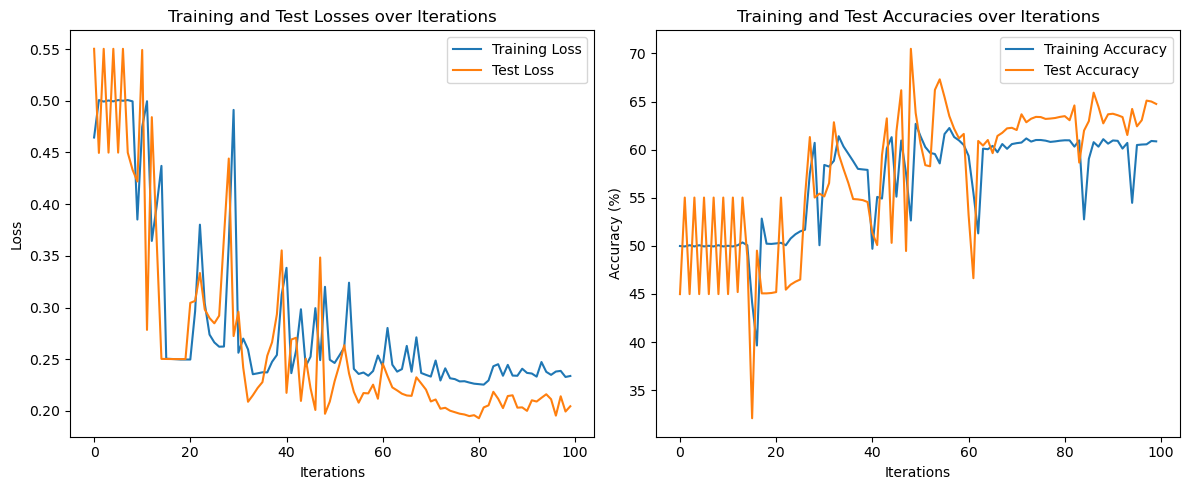

In [17]:
b = np.array([2,-2,-4])
nn = NeuralNetwork(X_train,y_train,128,128,1,b)
nn.loss = []
iterations = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for i in range(100):
    nn.feedforward()
    nn.backprop(0.001)
    iterations.append(i)

    # Training set evaluation
    train_loss = nn.loss[-1]
    train_losses.append(train_loss)
    train_accuracy = np.mean((nn.y_pred >= 0.5) == y_train) * 100
    train_accuracies.append(train_accuracy)
    # Test set evaluation
    nn.input = X_test
    nn.y = y_test
    nn.feedforward()
    test_loss = mean_squared_error(nn.y , nn.y_pred)
    test_losses.append(test_loss)
    test_accuracy = np.mean((nn.y_pred >= 0.5) == y_test) * 100
    test_accuracies.append(test_accuracy)
    # Reset input and y for the training set
    nn.input = X_train
    nn.y = y_train
    print(f'Iteration {i}:')
    print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy:.2f}%')
    print('-' * 40)

plt.figure(figsize=(12, 5))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(iterations, train_losses, label='Training Loss')
plt.plot(iterations, test_losses, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Test Losses over Iterations')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(iterations, train_accuracies, label='Training Accuracy')
plt.plot(iterations, test_accuracies, label='Test Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies over Iterations')
plt.legend()

plt.tight_layout()
plt.show()


